## **Aplicação de Random Forest Regression**
Neste notebook será aplicado o modelo Random Forest Regression utilizando as features extraídas dos dados .
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA**, **ETS** e **Regressão Linear**. 

In [67]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from src.features import add_trend
from src.evaluation import Evaluation
from src.plots import plot_metrics, plot_time_series

# configurando notebook
tqdm.pandas()
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)


%load_ext autoreload
%autoreload 2

EVAL_PATH = 'data/evaluation.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Leitura dos Dados**

In [68]:
# leitura dos dados
train_df = pd.read_csv("data/features_train_df.csv", parse_dates=['ds'], index_col=[0])
test_df = pd.read_csv("data/features_test_df.csv", parse_dates=['ds'], index_col=[0])

In [69]:
import json

with open("data/features.json", "r", encoding="utf-8") as arquivo:
    selected_features = json.load(arquivo)

In [70]:
best_models = {}

params= {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],   
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [71]:
def grid_search(estimator, X, y):
    splitter = TimeSeriesSplit(n_splits=3)
    search = GridSearchCV(
        cv=splitter,
        estimator=estimator,
        param_grid=params,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
    )
    search.fit(X, y)
    return search.best_params_


def xgboost(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo RandomForest.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train, fcst_df = add_trend(train, fcst_df)
    
    features = selected_features[train.unique_id[0]]
    best_model = grid_search(
        estimator=XGBRegressor(random_state=1001),
        X=train[features], 
        y=train.y
    )
    best_models[train.unique_id[0]] = best_model
    
    # best model fit_predict
    m = XGBRegressor(**best_model)
    m.fit(X=train[features], y=train.y)
    fcst_df['y_pred'] = m.predict(fcst_df[features])

    return fcst_df

In [72]:
# aplicando modelo para cada série
xgb_fcst = train_df.groupby("unique_id")\
    .progress_apply(xgboost)\
    .reset_index(drop=True)

100%|██████████| 15/15 [19:45<00:00, 79.04s/it]


In [73]:
with open("data/xgboost_best_model.json", "w", encoding="utf-8") as arquivo:
    json.dump(best_models, arquivo, ensure_ascii=False, indent=4)

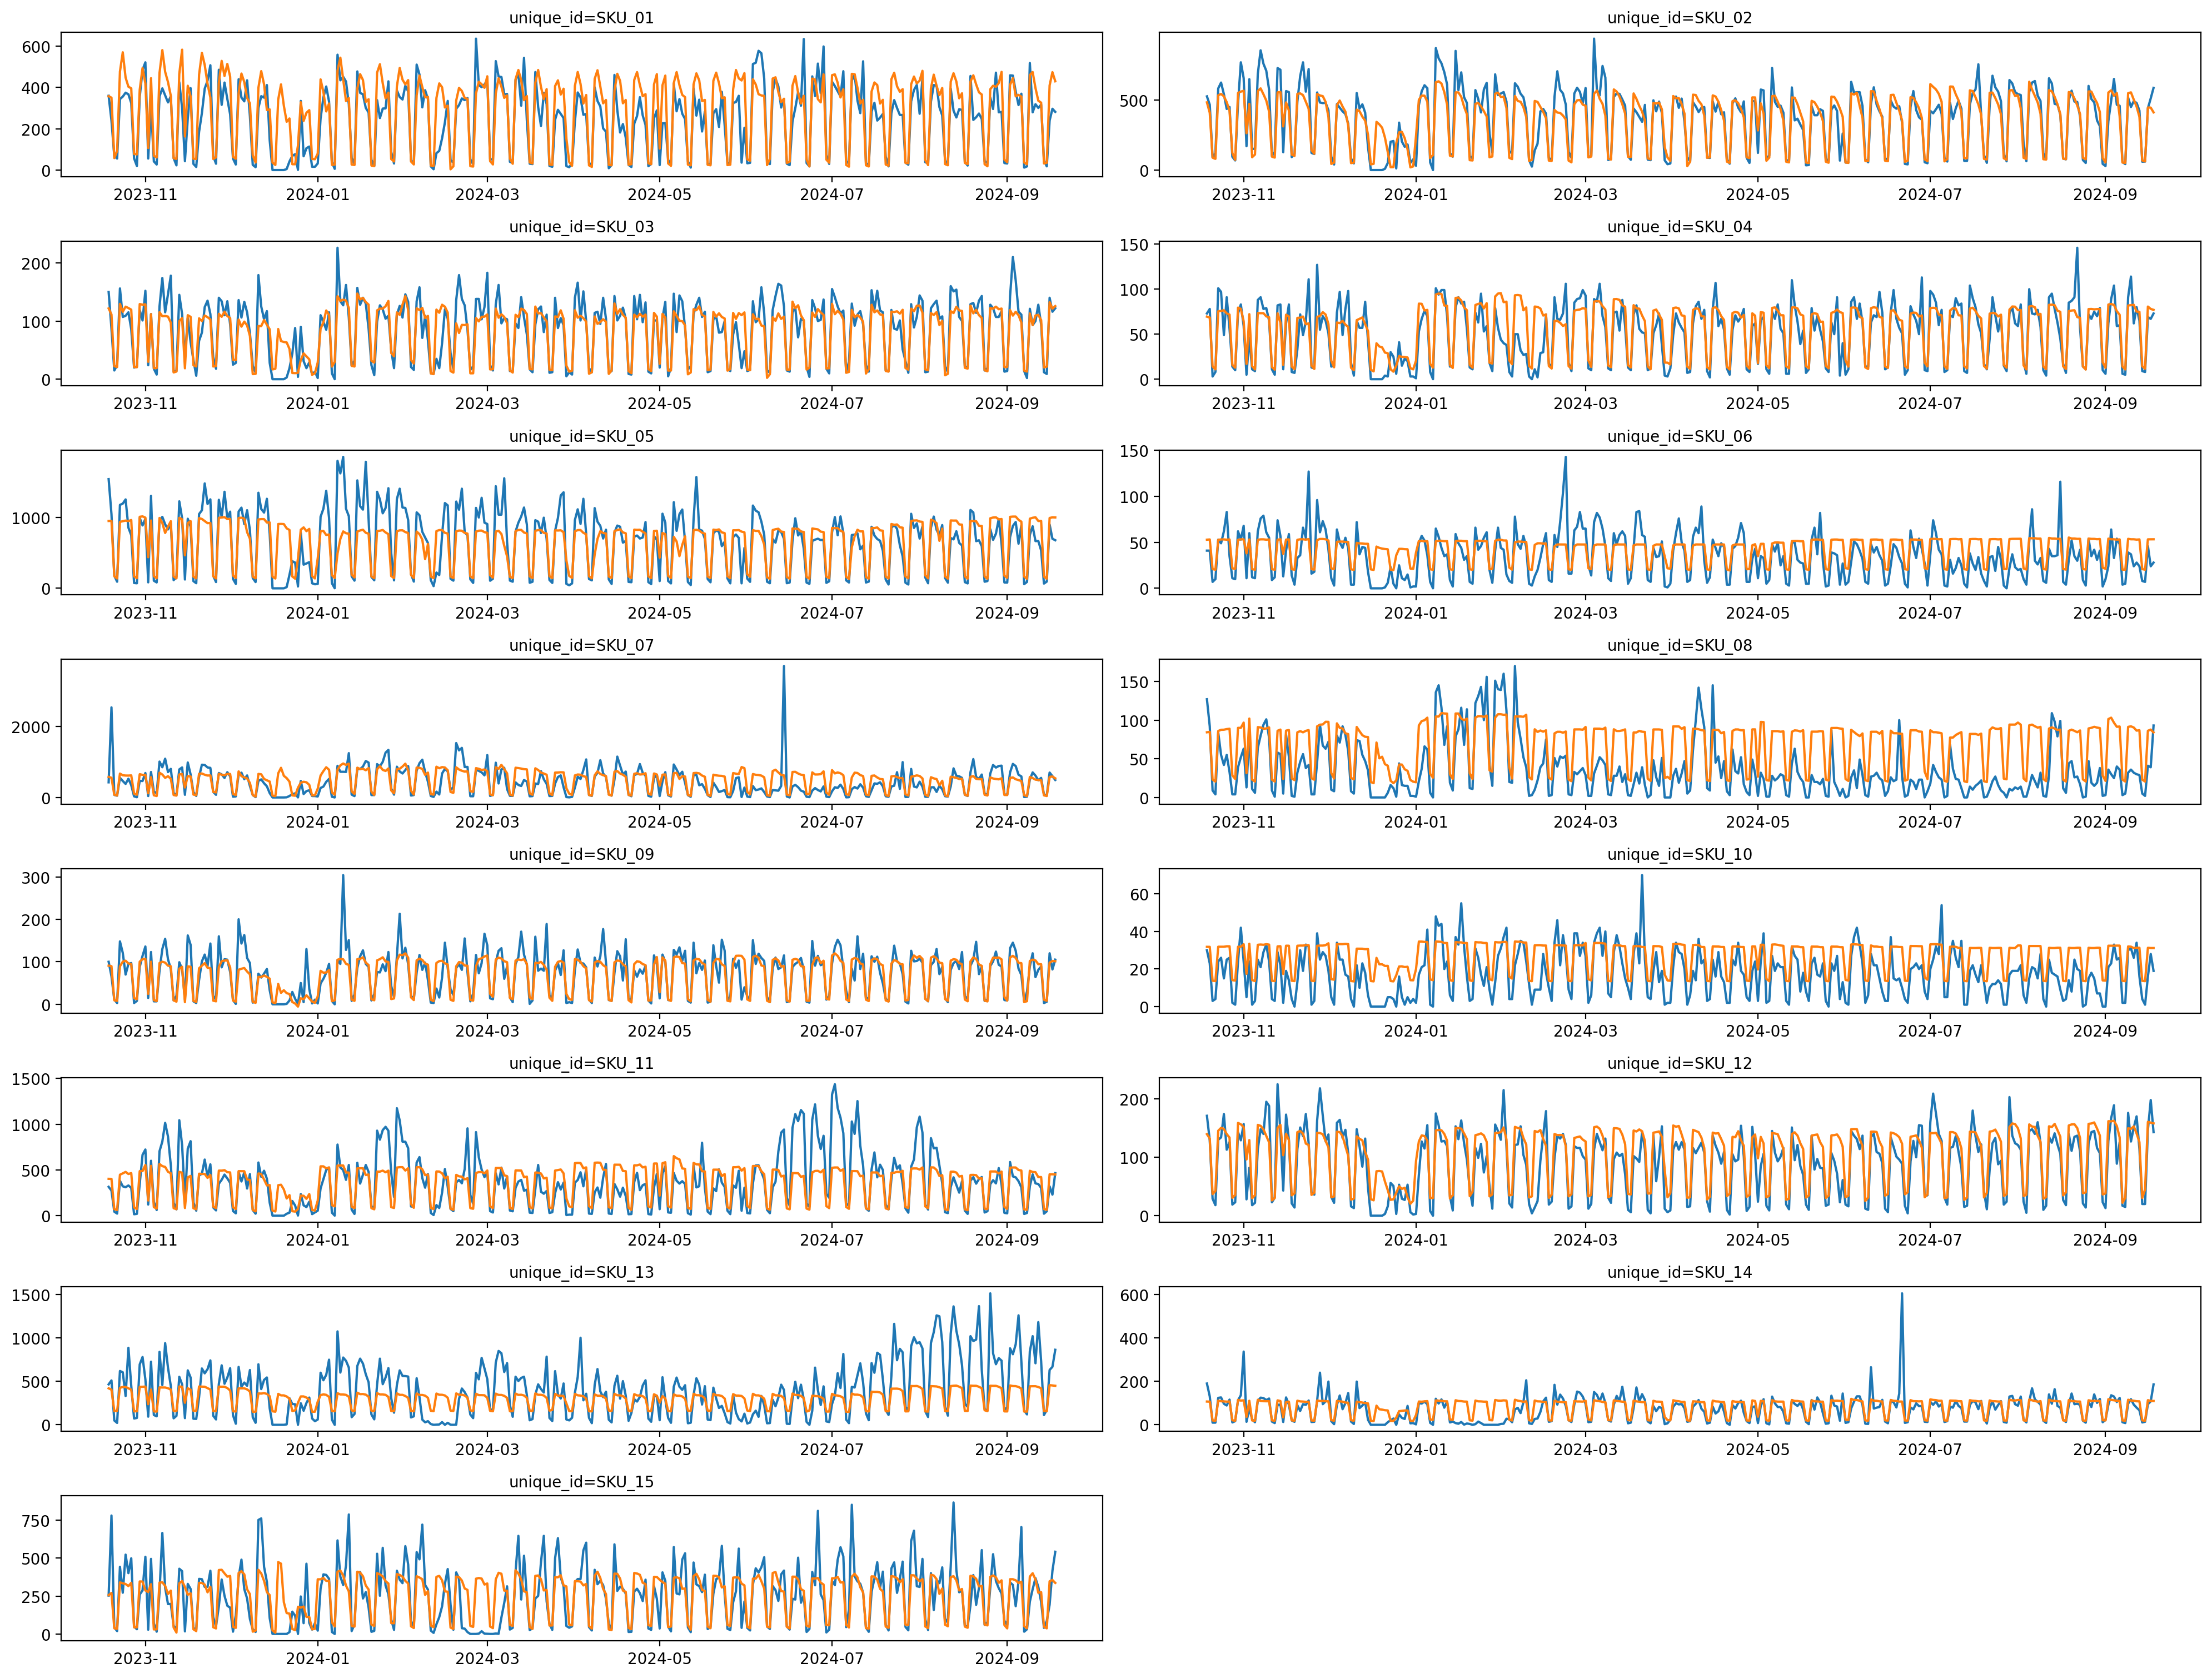

In [74]:
plt.rcParams["figure.dpi"] = 200

fig = plot_time_series(
    df=xgb_fcst, 
    figsize=(20, 16),
    data_cols=['y', 'y_pred'], 
)

In [75]:
rf_eval = Evaluation(xgb_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'XGBoost')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,80.30,12631.96,112.39,0.55
SKU_02,71.04,10551.04,102.72,0.79
SKU_03,18.50,736.73,27.14,0.74
SKU_04,13.03,342.64,18.51,0.69
SKU_05,192.74,78939.47,280.96,0.60
SKU_06,16.21,396.06,19.90,0.37
SKU_07,203.31,105590.26,324.95,0.35
SKU_08,38.22,1945.66,44.11,-0.51
SKU_09,18.67,836.69,28.93,0.69
SKU_10,10.80,149.96,12.25,0.07


In [76]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].unique()
metrics = metrics.pivot_table('r2','unique_id','model')[order]
metrics.T

unique_id,SKU_01,SKU_02,SKU_03,SKU_04,SKU_05,SKU_06,SKU_07,SKU_08,SKU_09,SKU_10,SKU_11,SKU_12,SKU_13,SKU_14,SKU_15
model,,,,,,,,,,,,,,,
Naive Sazonal,-0.39,0.09,-0.04,0.21,-0.45,0.08,-0.02,-1.22,-0.05,-0.80,-0.08,-0.25,-0.15,-0.05,-0.96
SARIMA,0.47,0.64,0.63,0.50,0.46,0.27,-0.79,-0.92,0.00,0.28,0.39,0.51,-0.01,0.21,-0.02
ETS,0.40,0.65,0.63,0.58,0.35,0.38,0.16,-0.93,0.53,-0.13,0.26,0.55,0.34,0.30,0.43
Random Forest,0.46,0.77,0.76,0.69,0.55,0.27,0.31,-0.92,0.69,-0.23,0.46,0.66,0.49,0.45,0.46
XGBoost,0.55,0.79,0.74,0.69,0.60,0.37,0.35,-0.51,0.69,0.07,0.47,0.68,0.30,0.42,0.45
